# AlexNet batch norm from scratch

In [1]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

In [2]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


train_data
actual labels: ['Lung_Opacity', 'Normal', 'Normal', 'Lung_Opacity']
numerical labels: tensor([1, 2, 2, 1])


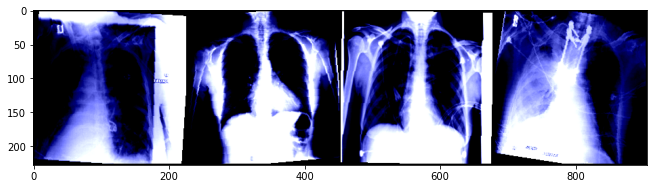

In [3]:
print('train_data')
show_img(datas[0])

In [4]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 16932
Length of Validation: 2117
Length of Testing: 2116


# AlexNet bn scratch Model

In [5]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 50

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [6]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes =4):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
            
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
            
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, ceil_mode=False),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits
    
        # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)
    
        # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

In [7]:
model = AlexNet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d

# Fine Tune fc + Train: AlexNet bn scratch


In [9]:
torch.manual_seed(RANDOM_SEED)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = NUM_EPOCHS, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/050 | Batch 0000/0265 | Loss: 1.4460
Epoch: 001/050 | Batch 0050/0265 | Loss: 1.0043
Epoch: 001/050 | Batch 0100/0265 | Loss: 0.8825
Epoch: 001/050 | Batch 0150/0265 | Loss: 0.6185
Epoch: 001/050 | Batch 0200/0265 | Loss: 0.8815
Epoch: 001/050 | Batch 0250/0265 | Loss: 0.6706
Epoch: 001/050 | Train: 70.47% | Validation: 70.62%
Time elapsed: 2.30 min
Epoch: 002/050 | Batch 0000/0265 | Loss: 0.7722
Epoch: 002/050 | Batch 0050/0265 | Loss: 0.7046
Epoch: 002/050 | Batch 0100/0265 | Loss: 0.8048
Epoch: 002/050 | Batch 0150/0265 | Loss: 0.6360
Epoch: 002/050 | Batch 0200/0265 | Loss: 0.9302
Epoch: 002/050 | Batch 0250/0265 | Loss: 0.7271
Epoch: 002/050 | Train: 74.18% | Validation: 72.18%
Time elapsed: 4.44 min
Epoch: 003/050 | Batch 0000/0265 | Loss: 0.7235
Epoch: 003/050 | Batch 0050/0265 | Loss: 0.6480
Epoch: 003/050 | Batch 0100/0265 | Loss: 0.7210
Epoch: 003/050 | Batch 0150/0265 | Loss: 0.4513
Epoch: 003/050 | Batch 0200/0265 | Loss: 0.4724
Epoch: 003/050 | Batch 0250/0265 |

Epoch: 023/050 | Batch 0200/0265 | Loss: 0.2991
Epoch: 023/050 | Batch 0250/0265 | Loss: 0.3045
Epoch: 023/050 | Train: 84.40% | Validation: 83.85%
Time elapsed: 52.28 min
Epoch: 024/050 | Batch 0000/0265 | Loss: 0.1908
Epoch: 024/050 | Batch 0050/0265 | Loss: 0.2786
Epoch: 024/050 | Batch 0100/0265 | Loss: 0.2208
Epoch: 024/050 | Batch 0150/0265 | Loss: 0.1077
Epoch: 024/050 | Batch 0200/0265 | Loss: 0.2095
Epoch: 024/050 | Batch 0250/0265 | Loss: 0.2852
Epoch: 024/050 | Train: 91.41% | Validation: 89.32%
Time elapsed: 54.83 min
Epoch: 025/050 | Batch 0000/0265 | Loss: 0.2469
Epoch: 025/050 | Batch 0050/0265 | Loss: 0.3113
Epoch: 025/050 | Batch 0100/0265 | Loss: 0.1321
Epoch: 025/050 | Batch 0150/0265 | Loss: 0.3117
Epoch: 025/050 | Batch 0200/0265 | Loss: 0.2386
Epoch: 025/050 | Batch 0250/0265 | Loss: 0.3542
Epoch: 025/050 | Train: 89.00% | Validation: 87.95%
Time elapsed: 57.16 min
Epoch: 026/050 | Batch 0000/0265 | Loss: 0.1345
Epoch: 026/050 | Batch 0050/0265 | Loss: 0.1839
Epoc

Epoch: 046/050 | Batch 0050/0265 | Loss: 0.2477
Epoch: 046/050 | Batch 0100/0265 | Loss: 0.1671
Epoch: 046/050 | Batch 0150/0265 | Loss: 0.1786
Epoch: 046/050 | Batch 0200/0265 | Loss: 0.1345
Epoch: 046/050 | Batch 0250/0265 | Loss: 0.1136
Epoch: 046/050 | Train: 93.09% | Validation: 90.88%
Time elapsed: 104.68 min
Epoch: 047/050 | Batch 0000/0265 | Loss: 0.2603
Epoch: 047/050 | Batch 0050/0265 | Loss: 0.2727
Epoch: 047/050 | Batch 0100/0265 | Loss: 0.1826
Epoch: 047/050 | Batch 0150/0265 | Loss: 0.0648
Epoch: 047/050 | Batch 0200/0265 | Loss: 0.1762
Epoch: 047/050 | Batch 0250/0265 | Loss: 0.0829
Epoch: 047/050 | Train: 95.26% | Validation: 92.49%
Time elapsed: 106.90 min
Epoch: 048/050 | Batch 0000/0265 | Loss: 0.2398
Epoch: 048/050 | Batch 0050/0265 | Loss: 0.0859
Epoch: 048/050 | Batch 0100/0265 | Loss: 0.0886
Epoch: 048/050 | Batch 0150/0265 | Loss: 0.1907
Epoch: 048/050 | Batch 0200/0265 | Loss: 0.2524
Epoch: 048/050 | Batch 0250/0265 | Loss: 0.1261
Epoch: 048/050 | Train: 94.90%

# Evaluation: AlexNet bn scratch

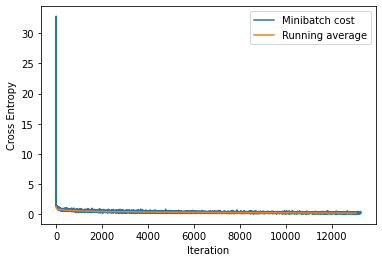

In [10]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

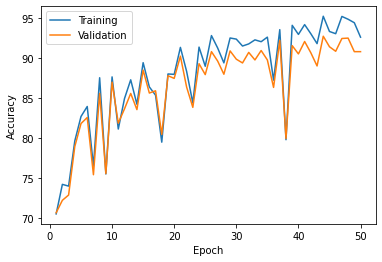

In [11]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

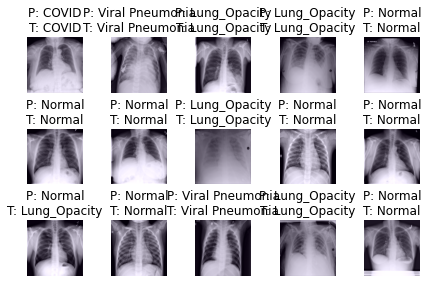

In [12]:
model.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

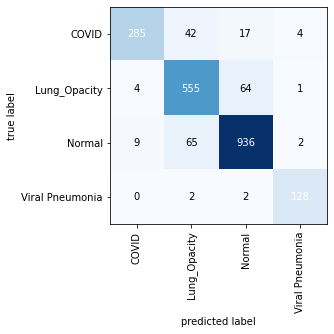

In [13]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Grad CAM

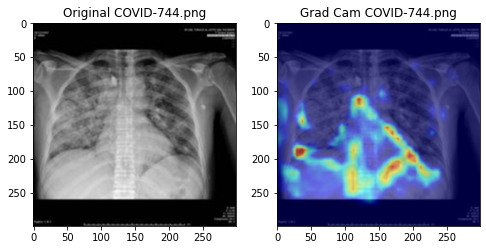

In [34]:
from helper_Gradcam import store_gradcam_image

i = 744
model_name, label = 'Alexnet','COVID'
store_gradcam_image(model, model_name, label,i)